<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/PyTorch/Nithin/DLS_Assignment_5_nvaradha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Learning Systems Fall 2022 Assignment 5

### Nithin Varadharajan (nvaradha)

### Problem 1: RNNs as a generative model

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a3887831-8a01-3d72-070f-e8adf393245a)


In [2]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [3]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [4]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [6]:
# Access my Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Get Datasets
import torchvision
mnist_train=torchvision.datasets.MNIST('mnist',
                                      train=True,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor()
                                                                                ]))

mnist_test=torchvision.datasets.MNIST('mnist',
                                      train=False,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor()
                                                                                ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [8]:
train_set_array = mnist_train.data
test_set_array = mnist_test.data

train_target = mnist_train.targets
test_target = mnist_test.targets

In [9]:
train_set_array = train_set_array / 255
test_set_array = test_set_array / 255

In [10]:
print(train_set_array.shape)
print(test_set_array.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [11]:
unfold = torch.nn.Unfold(kernel_size=7, stride = 7)

In [12]:

def get_patches(x):
  x = torch.unsqueeze(x, 0)
  x = torch.unsqueeze(x, 0)

  x = unfold(x)
  x = x.squeeze()
  x = x.T
  x = x.reshape(16,7,7)
  x = x.numpy().reshape(16,49)

  return x

In [13]:
# apply patching to all train images
new_x_train = []
for i in range(60000):
    new_x_train.append(get_patches(train_set_array[i,:,:]))

train_patch_set = np.array(new_x_train)
print(train_patch_set.shape)

(60000, 16, 49)


In [14]:
# applying the same patching to the test images
new_x_test = []
for i in range(10000):
    new_x_test.append(get_patches(test_set_array[i,:,:]))

test_patch_set = np.array(new_x_test)
print(test_patch_set.shape)

(10000, 16, 49)


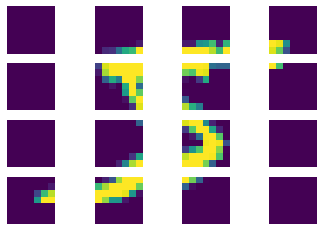

In [15]:
test_img = train_patch_set[0].reshape(16,7,7)

fig = plt.figure()
plt.subplots_adjust(wspace=.2, hspace=.2)
for i, img in enumerate(test_img):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('off')
    ax.imshow(img)
plt.show()

In [61]:
# Set Hyperparameters
n_epochs = 150 # max_epochs
batch_size_val = 100
batch_size_train = 100
batch_size_test = 100
learning_rate = 0.001 # learn rate
log_interval = 1 # log every _ epoch

patience = 8  # epochs after which training should stop if no improvement

In [62]:
# Get Datasets
from torch.utils.data import TensorDataset, DataLoader

Train_dataset_1 = TensorDataset(torch.from_numpy(train_patch_set[:,0:15,:].astype(float)), torch.from_numpy(train_patch_set[:,1:16,:].astype(float)))

Test_dataset_1 = TensorDataset(torch.from_numpy(test_patch_set[:,0:15,:].astype(float)), torch.from_numpy(test_patch_set[:,1:16,:].astype(float)))

train_loader = torch.utils.data.DataLoader(Train_dataset_1,batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(Test_dataset_1,batch_size=batch_size_val, shuffle=False)

In [63]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class RNN_network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.gru = nn.GRU(input_size = 49,
                            hidden_size = 49,
                            num_layers = 2,
                            batch_first = True
        ) 
  
        # self.fc1 = nn.Linear(15*64, 49*15)
        
        # Define extra layers 
        self.Tanh = nn.Tanh()
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Dropout = nn.Dropout(p=.1)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x, hx):
      
        # Pass the input tensor through each of our operations

        batch_size = x.size()[0]

        seq_size = x.size()[1]

        # h0 = torch.zeros(2, batch_size , 49).requires_grad_().to(device)

        x, hn = self.gru(x, hx)
      
        # x = x.reshape(batch_size, -1)

        x = self.Sigmoid(x)

        # x = self.Dropout(x)

        # x = self.fc1(x)

        # x = self.ReLU(x)

        x = x.reshape(batch_size,seq_size,49)

        return x, hn

In [64]:
# import math
# def weight_init(m):
#   if isinstance(m, nn.Linear):
#       # get the number of the inputs
#       n = m.in_features
#       y = 1.0/np.sqrt(n)
#       m.weight.data.uniform_(-y, y)
#       m.bias.data.fill_(0.0)
#   elif isinstance(m, nn.Conv2d):
#       torch.nn.init.xavier_uniform_(m.weight)
#       m.bias.data.fill_(0.0)

# Send model to GPU
RNN_network = RNN_network().to(device)
# CNN2D_network.apply(weight_init)
RNN_network = RNN_network.float()
print(RNN_network)

RNN_network(
  (gru): GRU(49, 49, num_layers=2, batch_first=True)
  (Tanh): Tanh()
  (ReLU): ReLU()
  (Sigmoid): Sigmoid()
  (Dropout): Dropout(p=0.1, inplace=False)
)


In [65]:
for name, param in RNN_network.named_parameters():
  if 'bias' in name:
    nn.init.zeros_(param)
  elif (('weight' in name) and ('lstm' in name)):
    nn.init.xavier_normal_(param)
  elif ('weight' in name):
    nn.init.kaiming_uniform_(param, nonlinearity = 'relu') # using uniform dists

In [66]:
# Define optimizer and loss
optimizer = torch.optim.Adam(RNN_network.parameters(), lr = learning_rate)
loss_func = torch.nn.MSELoss()

In [67]:
# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_metric =  float('inf') # captures best metric
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict)

In [79]:
from sklearn.metrics import mean_squared_error
import copy

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  stop_training = False # set to stop model training

  patience_rounds = 0 # number of patience rounds
 
  print("Training model")

  while ( (stop_training == False) and (epoch <= n_epochs) ):
    
    # Training
    RNN_network.train()
    train_loss = 0 # calc train loss
    for batch_idx, (data, target) in enumerate(train_loader):

      # Prepare batch data and labels
      input_data = data.to(device).float()
      batch_target = target.to(device)

      # Forward pass
      batch_size = data.size()[0]
      seq_size = data.size()[1]
      h0 = torch.zeros(2, batch_size , 49).requires_grad_().to(device)

      batch_out, temp_hn = RNN_network(input_data, h0)


      # res = torch.zeros(batch_size, seq_size, 49);

      # temp_hx = h0
      # for i in range(seq_size):
      #   temp_out, temp_hn = RNN_network(input_data[:,i,:], temp_hx)
      #   temp_hx = temp_hn

      #   res[:,i,:] = temp_out



      # batch_outputs = RNN_network(input_data.float())

      # x = (x>0.5).float()
      # loss = loss_func((batch_outputs.float() > 0.5).float(), batch_target.float())
      loss = loss_func(batch_out.float(), batch_target.float())

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() # increment train loss for epoch

    
   # Evaluation 
    RNN_network.eval()
    test_loss = 0
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):

        val_input = data.to(device)

        h0 = torch.zeros(2, batch_size , 49).requires_grad_().to(device)
        
        test_batch_pred, temp_hn = RNN_network.forward(val_input.float(), h0)
        
        val_batch_target = target.to(device)

        loss = loss_func(test_batch_pred.float(), val_batch_target.float())

        test_loss += loss.item()
      
        
    epoch_metric = test_loss 
    
    # Early Stop
    # if acc better than previous
    if(epoch_metric < bst_metric):
      # reset patience
      patience_rounds = 0

      # Save result
      bst_metric = epoch_metric

      # Save Model
      bst_model = copy.deepcopy(RNN_network) 
      bst_model_state_dict = RNN_network.state_dict()
      bst_opt_state_dict = optimizer.state_dict()
      # torch.save(model, 'best_mnist_model.pt')

    # if epoch acc worse
    else:
      # inc patience
      patience_rounds += 1
      if(patience_rounds >= patience):
        stop_training = True
        print("Stopping!")
    
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Total Validation Loss: {},  Best Validation Loss: {} \n ".format(epoch, train_loss,epoch_metric,  bst_metric))
    # increment epoch
    epoch += 1

  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict)
  return Training_Return

In [80]:
# Train 
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_metric, bst_model, bst_model_state_dict, bst_opt_state_dict = res

# Best Model
print("Best Metric Model was : {:.2f}".format(bst_metric))

Training model
Epoch: 1, Total Training Loss: 69.90340853482485, Total Validation Loss: 11.744487576186657,  Best Validation Loss: 11.744487576186657 
 
Epoch: 2, Total Training Loss: 69.85714656114578, Total Validation Loss: 11.739491000771523,  Best Validation Loss: 11.739491000771523 
 
Epoch: 3, Total Training Loss: 69.75539269298315, Total Validation Loss: 11.71722436696291,  Best Validation Loss: 11.71722436696291 
 
Epoch: 4, Total Training Loss: 69.6135742738843, Total Validation Loss: 11.683041408658028,  Best Validation Loss: 11.683041408658028 
 
Epoch: 5, Total Training Loss: 69.25626765191555, Total Validation Loss: 11.617957293987274,  Best Validation Loss: 11.617957293987274 
 
Epoch: 6, Total Training Loss: 66.88450276106596, Total Validation Loss: 10.357978366315365,  Best Validation Loss: 10.357978366315365 
 
Epoch: 7, Total Training Loss: 57.83489827811718, Total Validation Loss: 9.397681839764118,  Best Validation Loss: 9.397681839764118 
 
Epoch: 8, Total Training

In [137]:
RNN_network.eval()
with torch.no_grad():
  # for data, target in test_loader:

  test_img = torch.from_numpy(test_patch_set[0,0:8,:].astype(float))

  test_img = torch.unsqueeze(test_img, 0)

  h0 = torch.zeros(2,1, 49).to(device)

  data = test_img.to(device)

  test_batch_pred , hn = RNN_network.forward(data.float(), h0.float())

  print(test_batch_pred.shape)

torch.Size([1, 8, 49])


In [138]:
print(hn.shape)

torch.Size([2, 1, 49])


In [139]:
test_batch_pred_9 = torch.unsqueeze(test_batch_pred[:,7,:] , 0)

In [140]:
res = torch.zeros(1, 7, 49)

In [141]:
RNN_network.eval()
with torch.no_grad():

  temp_hx = hn
  temp_data = test_batch_pred_9
  for i in range(7):
    temp_out, temp_hn = RNN_network(temp_data, temp_hx)
    temp_hx = temp_hn
    temp_data = temp_out

    res[0,i,:] = temp_out[0, 0, :]


In [142]:
orig = torch.from_numpy(test_patch_set[0,0:8,:].astype(float))

print(orig.shape)

torch.Size([8, 49])


In [143]:
ress = torch.cat([orig,test_batch_pred[:,7,:].cpu(),res[0,:,:] ], 0)

ress = (ress.numpy()).reshape(16 ,7 ,7)

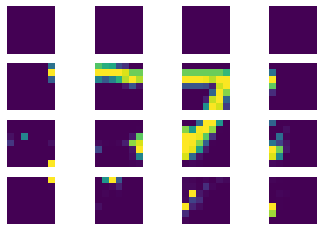

In [144]:
fig = plt.figure()
plt.subplots_adjust(wspace=.2, hspace=.2)
for i, img in enumerate(ress):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('off')
    ax.imshow(img)
plt.show()

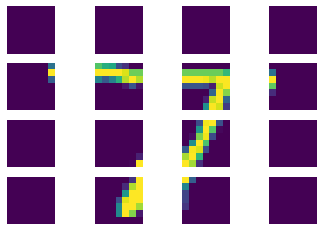

In [130]:
test_img = test_patch_set[0,:,:].reshape(16,7,7)
fig = plt.figure()
plt.subplots_adjust(wspace=.2, hspace=.2)
for i, img in enumerate(test_img):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray')
plt.show()

In [131]:

res = []
for i in range(10):
  res.append(np.array(np.where(test_target == i)[0][:10]))

final_array = np.concatenate(res, axis=0)

Original Images


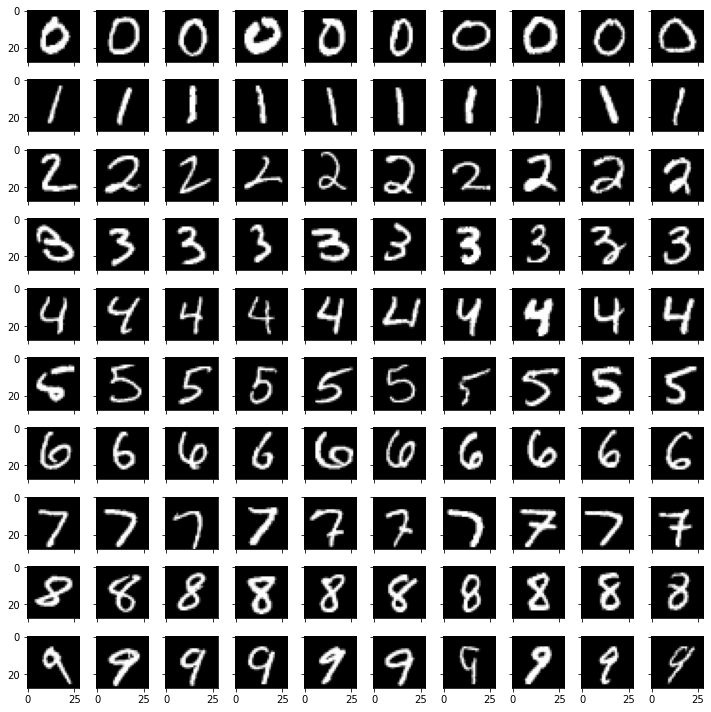

In [171]:
# Original Images
print("Original Images")
fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(test_set_array[final_array][cnt], cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()

In [166]:
# Generate bottom half of images using RNN
test_data = torch.from_numpy(test_patch_set[final_array])

final_predicted_imgs = torch.zeros(100, 8, 49)

final_image = np.zeros((100, 28, 28))

for img_i in range(100):

  RNN_network.eval()
  with torch.no_grad():

    first_half = test_data[img_i,0:8,:]

    first_half_1 = torch.unsqueeze(first_half, 0)

    h0 = torch.zeros(2,1,49).to(device)

    first_half_1 = first_half_1.to(device)

    test_batch_pred , hn9 = RNN_network.forward(first_half_1.float(), h0.float())

    test_batch_pred_9 = torch.unsqueeze(test_batch_pred[:,7,:] , 0)

    final_predicted_imgs[img_i,0,:] = test_batch_pred[0,7,:].cpu()

    temp_hx = hn9
    temp_data = test_batch_pred_9
    for i in range(1,8):
      temp_out, temp_hn = RNN_network(temp_data, temp_hx)
      temp_hx = temp_hn
      temp_data = temp_out

      final_predicted_imgs[img_i,i,:] = temp_out[0, 0, :].cpu()

  
    ress = torch.cat([first_half,final_predicted_imgs[img_i,:,:] ], 0)

    ress = (ress.numpy()).reshape(16 ,7 ,7)

    rows = torch.split(torch.from_numpy(ress), 28//7, dim =0)
    rows = [torch.cat(torch.unbind(x),dim=1) for x in rows] 
    reconstructed = torch.cat(rows,dim=0)

    final_image[img_i,:,:] = reconstructed.cpu().numpy()




Generated Images


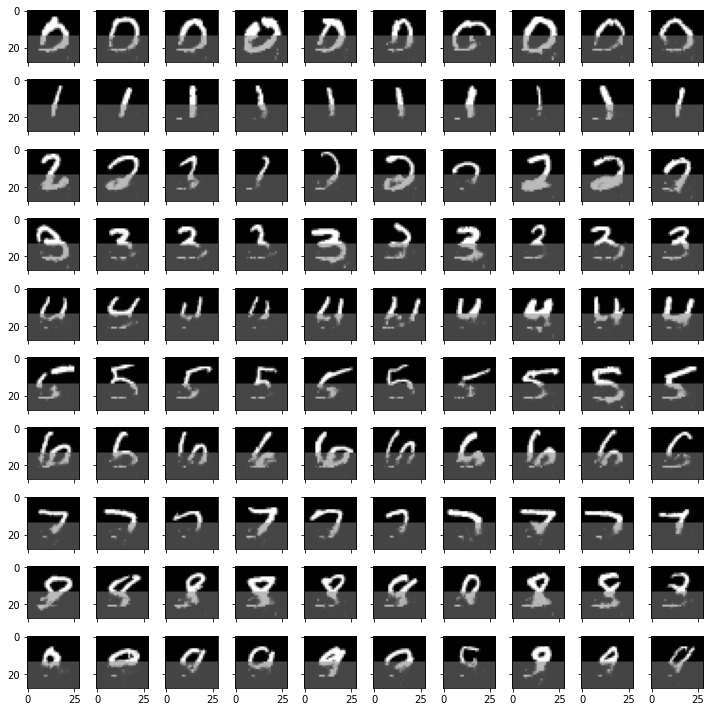

In [170]:
print("Generated Images")
fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(final_image[cnt,:,:], cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()

### Problem 2: Variational Autoencoders on Poor Sevens 

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [ ]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Access my Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/My Drive/DLS_Assignments/5/hw5_tr7.pkl', 'rb') as f:
    train_data = pickle.load(f)

In [ ]:
with open('/content/gdrive/My Drive/DLS_Assignments/5/hw5_te7.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
print(train_data.shape)
print(test_data.shape)

(6265, 28, 28)
(1028, 28, 28)


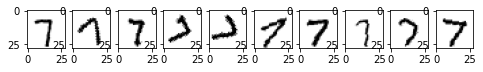

Train Data


In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1,10, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(train_data[i], cmap='gray_r')

plt.show()
print("Train Data")

In [ ]:
X_train = torch.from_numpy(train_data.astype(float))
X_test = torch.from_numpy(test_data.astype(float))

In [ ]:
# Set Hyperparameters
n_epochs = 50 # max_epochs
batch_size_val = 32
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.001 # learn rate
log_interval = 1 # log every _ epoch
k = 4 # latent dimensions

patience = 7  # epochs after which training should stop if no improvement

In [ ]:
# Get Datasets
from torch.utils.data import TensorDataset, DataLoader

Train_dataset = TensorDataset(X_train)
Test_dataset = TensorDataset(X_test)

train_loader = torch.utils.data.DataLoader(Train_dataset,batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(Test_dataset,batch_size=batch_size_val, shuffle=False)

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.finput = nn.Linear(784, 1024)
        # Output layer, 10 units - one for each digit
        self.ffc1 = nn.Linear(1024, 1024)
        self.ffc2 = nn.Linear(1024, 1024)
        self.ffc3 = nn.Linear(1024, 1024)
        self.ffc4 = nn.Linear(1024, 1024)
        self.foutput_mu = nn.Linear(1024, 4)
        self.foutput_var = nn.Linear(1024, 4)


        self.dinput = nn.Linear(4, 1024)
        self.dfc1 = nn.Linear(1024, 1024)
        self.dfc2 = nn.Linear(1024, 1024)
        self.dfc3 = nn.Linear(1024, 1024)
        self.dfc4 = nn.Linear(1024, 1024)
        self.doutput = nn.Linear(1024, 784)
        
        # Define extra layers 
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        # self.LeakyReLU = nn.LeakyReLU(leaky_relu_a)
        # self.Dropout = nn.Dropout(p=dropout)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)

    def encoder(self, x):
      
      x = self.finput(x)
      x = self.ReLU(x)

      x = self.ffc1(x)
      x = self.ReLU(x)

      x = self.ffc2(x)
      x = self.ReLU(x)

      x = self.ffc3(x)
      x = self.ReLU(x)

      x = self.ffc4(x)
      x = self.ReLU(x)

      mean = self.foutput_mu(x)
      logvar = self.foutput_var(x)

      return mean, logvar

    def decoder(self, z):

      x = self.dinput(z)
      x = self.ReLU(x)

      x = self.dfc1(x)
      x = self.ReLU(x)

      x = self.dfc2(x)
      x = self.ReLU(x)

      x = self.dfc3(x)
      x = self.ReLU(x)

      x = self.dfc4(x)
      x = self.ReLU(x)

      x = self.doutput(x)

      x = self.Sigmoid(x)

      return x
        
    def forward(self, x):

        # Flatten input 
        x = x.view(-1, 784)

        # Pass input through encoder
        mean, logvar = self.encoder(x)

        # Parametrize latent space

        standard_deviation = torch.exp(0.5 * logvar)

        epsilon = torch.randn_like(standard_deviation)

        z = torch.add(torch.mul(epsilon, standard_deviation), mean) 

        # Pass z through decoder

        output = self.decoder(z)

        return output, mean, logvar

In [ ]:
# Send model to GPU
VAE_Network = VAE_Network().to(device)
VAE_Network = VAE_Network.float()
print(VAE_Network)

VAE_Network(
  (finput): Linear(in_features=784, out_features=1024, bias=True)
  (ffc1): Linear(in_features=1024, out_features=1024, bias=True)
  (ffc2): Linear(in_features=1024, out_features=1024, bias=True)
  (ffc3): Linear(in_features=1024, out_features=1024, bias=True)
  (ffc4): Linear(in_features=1024, out_features=1024, bias=True)
  (foutput_mu): Linear(in_features=1024, out_features=4, bias=True)
  (foutput_var): Linear(in_features=1024, out_features=4, bias=True)
  (dinput): Linear(in_features=4, out_features=1024, bias=True)
  (dfc1): Linear(in_features=1024, out_features=1024, bias=True)
  (dfc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dfc3): Linear(in_features=1024, out_features=1024, bias=True)
  (dfc4): Linear(in_features=1024, out_features=1024, bias=True)
  (doutput): Linear(in_features=1024, out_features=784, bias=True)
  (ReLU): ReLU()
  (Sigmoid): Sigmoid()
)


In [ ]:
def loss_function(x, reconstruction_x, mean, logvar):

        # Likelihood term 
        Binary_cross_entropy = F.binary_cross_entropy(input = reconstruction_x.view(-1, 784), target= x.view(-1, 784), reduction='sum')

        # Regularization term 
        KL_Drivergence = -0.5 * torch.sum( 1 + logvar - torch.square(mean) - torch.exp(logvar) )  

        Total_loss = Binary_cross_entropy + KL_Drivergence
        
        return Total_loss


In [ ]:
# Define optimizer and loss

optimizer = torch.optim.Adam(VAE_Network.parameters(), lr = learning_rate)

In [ ]:
import numpy as np

# Results of Training
bst_prediction_array = None
bst_test_data = None
bst_test_labels = None
bst_accuracy = float('inf') # captures best accuracy
bst_model = None
bst_model_state_dict = None
bst_opt_state_dict = None

Training_Result = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict)

In [ ]:
from sklearn.metrics import accuracy_score

import copy

# Train Function
def train(Training_Result_p):

  bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  stop_training = False # set to stop model training

  patience_rounds = 0 # number of patience rounds
 
  
  print("Training model")

  while ( (stop_training == False) and (epoch <= n_epochs) ):
    
    # Training
    VAE_Network.train()
    train_loss = 0 # calc train loss
    for batch_idx,(data) in enumerate(train_loader):

      # Prepare batch data and labels
      data = data[0].to(device)

      # Forward pass
      output, mean, logvar = VAE_Network.forward(data.float())
      loss = loss_function(data.float(), output, mean, logvar)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()  # increment train loss for epoch

    train_loss = train_loss / 6265.0

    # Evaluation 
    VAE_Network.eval()
    val_loss = 0 # calc val loss
    with torch.no_grad():
      for batch_idx,(data) in enumerate(test_loader):
        
        data = data[0].to(device)
        # Forward pass
        output, mean, logvar = VAE_Network.forward(data.float())
        loss = loss_function(data.float(), output, mean, logvar)

        val_loss += loss.item() 

    val_loss = val_loss / 1028.0
    
    # Early Stop
    # if acc better than previous
    if(val_loss < bst_accuracy):
      # reset patience
      patience_rounds = 0

      # Save result
      bst_accuracy = val_loss

      # Save Model
      bst_model = VAE_Network
      bst_model_state_dict = copy.deepcopy(VAE_Network.state_dict())
      bst_opt_state_dict = copy.deepcopy(optimizer.state_dict())
      # torch.save(model, 'best_mnist_model.pt')

    # if epoch acc worse
    else:
      # inc patience
      patience_rounds += 1
      if(patience_rounds >= patience):
        stop_training = True
        print("Stopping!")
  
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Total Training Loss: {}, Val Loss: {}, Best Val Loss: {} \n ".format(epoch, train_loss, val_loss, bst_accuracy))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict)
  return Training_Return

In [ ]:
# Train MNIST with test set as validation
res = train(Training_Result)

bst_prediction_array, bst_test_data, bst_test_labels, bst_accuracy, bst_model, bst_model_state_dict, bst_opt_state_dict = res


Training model
Epoch: 1, Total Training Loss: 198.0372248790403, Val Loss: 187.27883762701012, Best Val Loss: 187.27883762701012 
 
Epoch: 2, Total Training Loss: 174.05159878011523, Val Loss: 163.23337427280293, Best Val Loss: 163.23337427280293 
 
Epoch: 3, Total Training Loss: 160.17184094111633, Val Loss: 159.7810771660118, Best Val Loss: 159.7810771660118 
 
Epoch: 4, Total Training Loss: 155.54413045409765, Val Loss: 158.52187914421586, Best Val Loss: 158.52187914421586 
 
Epoch: 5, Total Training Loss: 153.13680869039305, Val Loss: 146.24221371305592, Best Val Loss: 146.24221371305592 
 
Epoch: 6, Total Training Loss: 147.49644322376298, Val Loss: 143.34642503790354, Best Val Loss: 143.34642503790354 
 
Epoch: 7, Total Training Loss: 143.49400380493066, Val Loss: 139.03847806462983, Best Val Loss: 139.03847806462983 
 
Epoch: 8, Total Training Loss: 139.906220968114, Val Loss: 136.80333801744513, Best Val Loss: 136.80333801744513 
 
Epoch: 9, Total Training Loss: 136.66136943211

In [ ]:
# Save the model 

torch.save( bst_model_state_dict, '/content/gdrive/My Drive/DLS_Assignments/5/q2_base_state.pt')

In [ ]:
# load the model if it needs to be

VAE_Network.load_state_dict(torch.load('/content/gdrive/My Drive/DLS_Assignments/5/q2_base_state.pt', map_location=torch.device('cpu'))) # , map_location=torch.device('cpu')

<All keys matched successfully>

Example Generated Images from random dist

In [ ]:
random_z = torch.normal(mean=0, std=1, size=(10, 4)).float().to(device)

In [ ]:
#Forward through the decoder
random_generated_imgs = None
with torch.no_grad():
  random_generated_imgs = VAE_Network.decoder(random_z)
  random_generated_imgs = random_generated_imgs.cpu().numpy()
  random_generated_imgs = random_generated_imgs.reshape(-1,28,28)

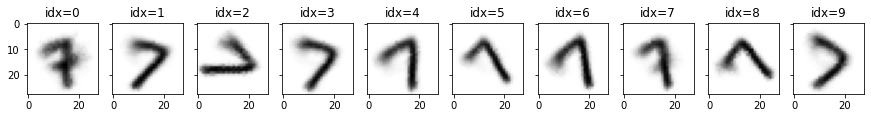

Train Data


In [ ]:
fig, axes = plt.subplots(1,10, figsize=(15,15), sharey=True, sharex=True)
for i,ax in enumerate(axes.flat):

    ax.imshow(random_generated_imgs[i], cmap='gray_r')
    ax.set_title("idx="+str(i))

plt.show()
print("Train Data")

In [ ]:
varying_dim = [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0 , 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
print(len(varying_dim))

13


In [ ]:
new_z = np.zeros(shape=(4,13, 4))

for i in range(4):

  val = np.random.normal(loc=0, scale=1, size=3)
  val_idx = 0
  for j in range(4):
    if(i == j):
      new_z[i,:,j] = np.array(varying_dim)
    else:
      new_z[i,:,j] = np.full((13,), val[val_idx])
      val_idx += 1

new_z = torch.tensor(new_z).float().to(device)

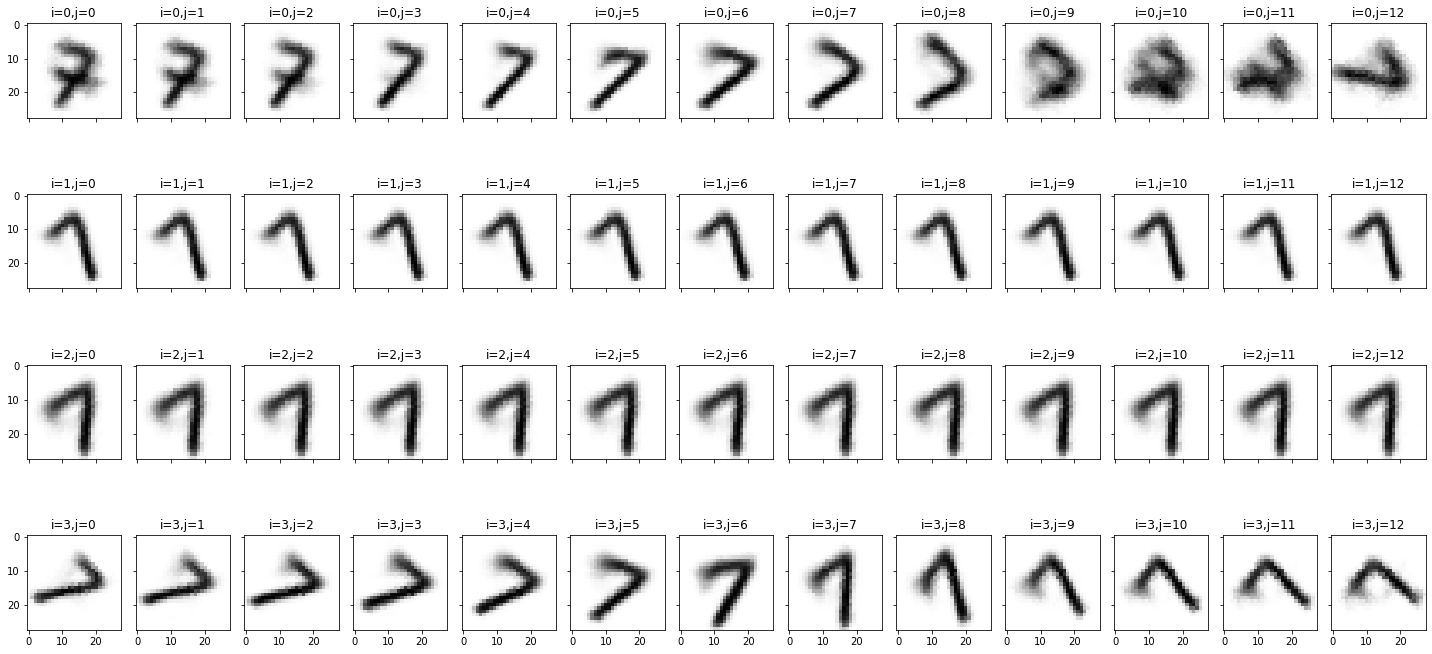

Data with each K varied while others are fixed


In [ ]:
fig, axes = plt.subplots(4,13, figsize=(20,10), sharey=True, sharex=True)

#Forward through the decoder
random_generated_imgs = np.zeros(shape=(4,13,28,28))
with torch.no_grad():
  for i in range(4):
    random_generated_imgs[i,:,:,:] = VAE_Network.decoder(new_z[i]).cpu().numpy().reshape(-1,28,28)

for i in range(4):
  for j in range(13):
    ax = axes[i,j]
    ax.imshow(random_generated_imgs[i,j], cmap='gray_r')
    ax.set_title("i={},j={}".format(i,j))
fig.tight_layout() 
plt.show()
print("Data with each K varied while others are fixed")

Looking at my output of the VAE decoder where the input z has one dimension varied and the others fixed, the dimesion that shows similar-looking 7's with a gradually changing effect is dimension 4 or i = 3. So I think it was added by the professor. Here all the 7's are gradually rotating. Where as in the other dimensions either the 7's don't look similar or aren't rotating. 

### Problem 3: Conditional GAN

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-29b601d2-c725-81ae-c6c3-2ebd6af44407)


In [ ]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Access my Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Get Datasets
import torchvision
mnist_train=torchvision.datasets.MNIST('mnist',
                                      train=True,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor()
                                                                                ]))

mnist_test=torchvision.datasets.MNIST('mnist',
                                      train=False,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor()
                                                                                ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
# Set Hyperparameters
n_epochs = 200 # max_epochs
batch_size_train = 100 # batch size train set
batch_size_test = 100 # batch size test set
learning_rate = 0.0001 # learn rate
log_interval = 1 # log every _ epoch

patience = 15  # epochs after which training should stop if no improvement

In [ ]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size_test, shuffle=False)

In [ ]:
# X_train = X_train.astype(float)
# X_train = (((X_train / 255) * 2) - 1)

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Gen_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(110, 200)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(200, 400)
        self.fc2 = nn.Linear(400, 1024)
        self.output = nn.Linear(1024, 784)

        # Define extra layers 
        #self.ReLU = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.Tanh = nn.Tanh()
        # self.Dropout = nn.Dropout(p=dropout)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x, label_vector):

        x = x.view(x.size(0), 100)

        one_hot_labels = F.one_hot(label_vector, num_classes=10) # one hot conversion

        input_tensor = torch.concat((x,one_hot_labels), 1) # B * 100 , B * 10
      
        # Pass the input tensor through each of our operations
        x = self.input(input_tensor)
        x = self.LeakyReLU(x)

        x = self.fc1(x)
        x = self.LeakyReLU(x)

        x = self.fc2(x)
        x = self.LeakyReLU(x)

        x = self.output(x)
        x = self.Tanh(x)
        return x

In [ ]:
class Disc_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(794, 400)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(400, 200)
        self.fc2 = nn.Linear(200, 100)
        self.output = nn.Linear(100, 1)

        # Define extra layers 
        #self.ReLU = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.Sigmoid = nn.Sigmoid()
        self.Dropout = nn.Dropout(p=0.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x, label_vector):

        one_hot_labels = F.one_hot(label_vector, num_classes=10) # one hot conversion

        input_tensor = torch.concat((x,one_hot_labels), 1) # B * 100 , B * 10
      
        # Pass the input tensor through each of our operations
        x = self.input(input_tensor)
        x = self.LeakyReLU(x)
        x = self.Dropout(x)

        x = self.fc1(x)
        x = self.LeakyReLU(x)
        x = self.Dropout(x)

        x = self.fc2(x)
        x = self.LeakyReLU(x)
        x = self.Dropout(x)

        x = self.output(x)
        x = self.Sigmoid(x)
        return x.squeeze()

In [ ]:
# Send model to GPU
Gen_Network = Gen_Network().to(device)
Gen_Network = Gen_Network.float()
print(Gen_Network)

Gen_Network(
  (input): Linear(in_features=110, out_features=200, bias=True)
  (fc1): Linear(in_features=200, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=784, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (Tanh): Tanh()
)


In [ ]:
Disc_Network = Disc_Network().to(device)
Disc_Network = Disc_Network.float()
print(Disc_Network)

Disc_Network(
  (input): Linear(in_features=794, out_features=400, bias=True)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (Sigmoid): Sigmoid()
  (Dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
# Define optimizer and loss

discriminator_optimizer = torch.optim.Adam(Disc_Network.parameters(), lr=0.0002)
generator_optimizer = torch.optim.Adam(Gen_Network.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [ ]:
import numpy as np

# Results of Training
real_accuracy = []
fake_accuracy = []
gen_loss = []
disc_loss = []

Training_Result = (real_accuracy, fake_accuracy, gen_loss, disc_loss)

In [ ]:
from sklearn.metrics import accuracy_score

import copy

# Train Function
def train(Training_Result_p):

  real_accuracy, fake_accuracy, gen_loss, disc_loss = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  stop_training = False # set to stop model training
 
  
  print("Training model")

  while ( (epoch <= n_epochs) ):
    temp_r=0
    temp_f=0
    temp_dloss = 0
    temp_gloss = 0
    cnt = 0

    # Training
    for batch_idx,(data, target) in enumerate(train_loader):

      
      # First Generation Pass
      noise_vector = torch.randn(batch_size_train,100).to(device)

      gen_fake_lbls = [i for j in range(10) for i in range(10)]
      gen_fake_lbls = torch.from_numpy(np.array(gen_fake_lbls)).to(device)

      fake_data = Gen_Network(noise_vector.float(), gen_fake_lbls) # flattened output

      # Discriminator Step
      real_data = data.view(100, 784).to(device).float()

        # convert real_data from 0, 1 to -1, +1
      real_data = ((real_data * 2) - 1)

      data_digit_labels = target.to(device)

      real_labels = torch.ones(100).to(device)
      fake_labels_zero = torch.zeros(100).to(device)

        # Disc forward pass real data
      disc_out_real = Disc_Network(real_data, data_digit_labels).reshape(100)
      disc_loss_real = loss(disc_out_real, real_labels)

        # Disc forward pass fake data
      disc_out_fake = Disc_Network(fake_data, gen_fake_lbls).reshape(100)
      disc_loss_fake = loss(disc_out_fake, fake_labels_zero)

        # average loss
      final_disc_loss = (disc_loss_real + disc_loss_fake) / 2

        # Disc Backward and optimize
      discriminator_optimizer.zero_grad()
      final_disc_loss.backward()
      discriminator_optimizer.step()

      temp_r += accuracy_score(real_labels.detach().cpu().numpy(), (disc_out_real>0.5).float().detach().cpu().numpy() ) # ?

      temp_f += accuracy_score(fake_labels_zero.detach().cpu().numpy(), (disc_out_fake>0.5).float().detach().cpu().numpy() ) # ?

      cnt += 1

      temp_dloss += final_disc_loss.item()

      # Generator Step

      # using same random vector from first step but regenerating

      fake_data_gen = Gen_Network(noise_vector.float(), gen_fake_lbls) # flattened output

      disc_out_fake_gen = Disc_Network(fake_data_gen, gen_fake_lbls).reshape(100)

      gen_loss_fake = loss(disc_out_fake_gen, real_labels) # want gen examples to be seen as real , 1

      # Gen Backward and optimize
      generator_optimizer.zero_grad()
      gen_loss_fake.backward()
      generator_optimizer.step()

      temp_gloss += gen_loss_fake.item()

     


    real_accuracy.append(temp_r/cnt) 
      
    fake_accuracy.append(temp_f/cnt) 

    disc_loss.append(temp_dloss)

    gen_loss.append(temp_gloss)


  
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Disc Loss: {}, Gen Loss: {}, Real Acc: {} Fake Acc: {} \n ".format(epoch, temp_dloss, temp_gloss, temp_r/cnt, temp_f/cnt))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (real_accuracy, fake_accuracy, gen_loss, disc_loss)
  return Training_Return

In [ ]:
# Train MNIST with test set as validation
res = train(Training_Result)

real_accuracy, fake_accuracy, gen_loss, disc_loss = res


Training model
Epoch: 1, Disc Loss: 353.9878933727741, Gen Loss: 763.927617251873, Real Acc: 0.799483333333333 Fake Acc: 0.5608666666666668 
 
Epoch: 2, Disc Loss: 377.9156665503979, Gen Loss: 526.3233557343483, Real Acc: 0.7686333333333338 Fake Acc: 0.5353333333333332 
 
Epoch: 3, Disc Loss: 332.84746681153774, Gen Loss: 857.467709094286, Real Acc: 0.7736166666666673 Fake Acc: 0.6591999999999999 
 
Epoch: 4, Disc Loss: 252.90976265072823, Gen Loss: 1323.999608039856, Real Acc: 0.7971000000000001 Fake Acc: 0.8284000000000006 
 
Epoch: 5, Disc Loss: 228.0184270069003, Gen Loss: 1422.7878979444504, Real Acc: 0.8126166666666662 Fake Acc: 0.8646500000000007 
 
Epoch: 6, Disc Loss: 212.14221899211407, Gen Loss: 1272.126148223877, Real Acc: 0.820266666666667 Fake Acc: 0.8839500000000008 
 
Epoch: 7, Disc Loss: 199.887828245759, Gen Loss: 1390.2199759483337, Real Acc: 0.8293666666666659 Fake Acc: 0.8928999999999998 
 
Epoch: 8, Disc Loss: 198.2003390043974, Gen Loss: 1322.6005840301514, Real 

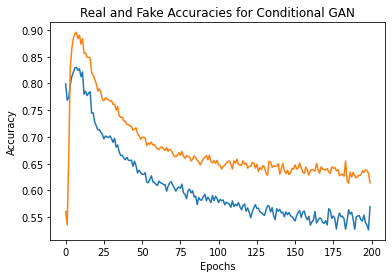

In [ ]:
_ = plt.plot(real_accuracy, label='Real Accuracy')
_ = plt.plot(fake_accuracy, label='Fake Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Real and Fake Accuracies for Conditional GAN")
plt.show()

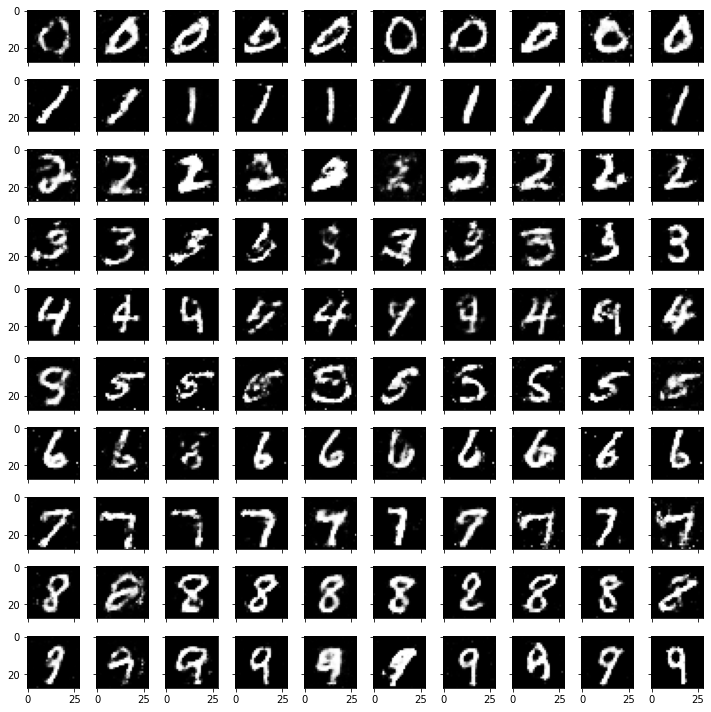

In [ ]:
# Output of Generator for MNIST Conditional GAN
noise_vector = torch.randn(batch_size_train,100).to(device)

gen_fake_lbls = [i for i in range(10) for j in range(10)]
gen_fake_lbls = torch.from_numpy(np.array(gen_fake_lbls)).to(device)

fake_data = Gen_Network(noise_vector.float(), gen_fake_lbls)

fake_data = fake_data.detach().cpu().numpy()

# Convert back 0,1
fake_data = (0.5 * fake_data) + 0.5

fake_data = fake_data.reshape(-1, 28, 28)

fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(fake_data[cnt, :, :], cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()


### Problem 4: Missing Value Imputation Using Conditional GAN

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-84ea646d-b026-a8a1-65aa-9a6db9a8068e)


In [ ]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [ ]:
# Set torch random seed 
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Access my Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Get Datasets
import torchvision
mnist_train=torchvision.datasets.MNIST('mnist',
                                      train=True,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor()
                                                                                ]))

mnist_test=torchvision.datasets.MNIST('mnist',
                                      train=False,
                                      download=True,
                                      transform=torchvision.transforms.Compose([
                                                                                torchvision.transforms.ToTensor()
                                                                                ]))

In [ ]:
# Set Hyperparameters
n_epochs = 200 # max_epochs
batch_size_train = 100 # batch size train set
batch_size_test = 100 # batch size test set
learning_rate = 0.0001 # learn rate
log_interval = 1 # log every _ epoch

patience = 15  # epochs after which training should stop if no improvement

In [ ]:
# Define data loaders
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size_test, shuffle=False)

In [ ]:
# Building the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Gen_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(200, 500)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(500, 1024)
        self.output = nn.Linear(1024, 784)

        # Define extra layers 
        #self.ReLU = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.Tanh = nn.Tanh()
        # self.Dropout = nn.Dropout(p=dropout)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x, conditioning_vector):

        input_tensor = torch.concat((x,conditioning_vector), 1) # B * 100 , B * 100
      
        # Pass the input tensor through each of our operations
        x = self.input(input_tensor)
        x = self.LeakyReLU(x)

        x = self.fc1(x)
        x = self.LeakyReLU(x)

        x = self.output(x)
        x = self.Tanh(x)
        return x

In [ ]:
class Disc_Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.input = nn.Linear(784, 400)
        # Output layer, 10 units - one for each digit
        self.fc1 = nn.Linear(400, 200)
        self.fc2 = nn.Linear(200, 100)
        self.output = nn.Linear(100, 1)

        # Define extra layers 
        #self.ReLU = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.Sigmoid = nn.Sigmoid()
        self.Dropout = nn.Dropout(p=0.2)
        #self.GroupNorm = nn.GroupNorm(group_num, 1024)
        
    def forward(self, x):

        # Pass the input tensor through each of our operations
        x = self.input(x)
        x = self.LeakyReLU(x)
        x = self.Dropout(x)

        x = self.fc1(x)
        x = self.LeakyReLU(x)
        x = self.Dropout(x)

        x = self.fc2(x)
        x = self.LeakyReLU(x)
        x = self.Dropout(x)

        x = self.output(x)
        x = self.Sigmoid(x)
        return x.squeeze()

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform(m.weight)
      m.bias.data.fill_(0.01)

# Send model to GPU
Gen_Network = Gen_Network().to(device)
Gen_Network = Gen_Network.float()
Gen_Network.apply(init_weights)
print(Gen_Network)

Gen_Network(
  (input): Linear(in_features=200, out_features=500, bias=True)
  (fc1): Linear(in_features=500, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=784, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (Tanh): Tanh()
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Disc_Network = Disc_Network().to(device)
Disc_Network = Disc_Network.float()
Disc_Network.apply(init_weights)
print(Disc_Network)

Disc_Network(
  (input): Linear(in_features=784, out_features=400, bias=True)
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (Sigmoid): Sigmoid()
  (Dropout): Dropout(p=0.2, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Define optimizer and loss

discriminator_optimizer = torch.optim.Adam(Disc_Network.parameters(), lr=0.0002)
generator_optimizer = torch.optim.Adam(Gen_Network.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [ ]:
import numpy as np

# Results of Training
real_accuracy = []
fake_accuracy = []
gen_loss = []
disc_loss = []

Training_Result = (real_accuracy, fake_accuracy, gen_loss, disc_loss)

In [ ]:
from sklearn.metrics import accuracy_score

import copy

# Train Function
def train(Training_Result_p):

  real_accuracy, fake_accuracy, gen_loss, disc_loss = Training_Result_p

  # Train parameters
  epoch = 1 # starting epoch

  stop_training = False # set to stop model training
 
  
  print("Training model")

  while ( (epoch <= n_epochs) ):
    temp_r=0
    temp_f=0
    temp_dloss = 0
    temp_gloss = 0
    cnt = 0

    # Training
    for batch_idx,(data, target) in enumerate(train_loader):


      # Discriminator Step

      data = data.to(device).float()

      # convert real_data from 0, 1 to -1, +1
      data = ((data * 2) - 1)

      # First Generation Pass
      noise_vector = torch.randn(batch_size_train,100).to(device).float()

      data_for_gen = data.reshape(100, 28,28)

      data_patches = data_for_gen[:,10:20,10:20]

      data_patches = data_patches.reshape(100, 100)


      fake_data = Gen_Network(noise_vector, data_patches) # flattened output


      real_data_flat = data.reshape(100, 784)

      real_labels = torch.ones(100).to(device)
      fake_labels_zero = torch.zeros(100).to(device)

        # Disc forward pass real data
      disc_out_real = Disc_Network(real_data_flat).reshape(100)
      disc_loss_real = loss(disc_out_real, real_labels)

      
        # Disc forward pass fake data
      disc_out_fake = Disc_Network(fake_data).reshape(100)
      disc_loss_fake = loss(disc_out_fake, fake_labels_zero)

        # average loss
      final_disc_loss = (disc_loss_real + disc_loss_fake) / 2

        # Disc Backward and optimize
      discriminator_optimizer.zero_grad()
      final_disc_loss.backward()
      discriminator_optimizer.step()

      temp_r += accuracy_score(real_labels.detach().cpu().numpy(), (disc_out_real>0.5).float().detach().cpu().numpy() ) # ?

      temp_f += accuracy_score(fake_labels_zero.detach().cpu().numpy(), (disc_out_fake>0.5).float().detach().cpu().numpy() ) # ?

      cnt += 1

      temp_dloss += final_disc_loss.item()

      # Generator Step

      # using same random vector from first step but regenerating

      # noise_vector = torch.randn(batch_size_train,100).to(device).float()

      fake_data_gen = Gen_Network(noise_vector, data_patches) # flattened output

      disc_out_fake_gen = Disc_Network(fake_data_gen).reshape(100)


      # Get fake conditioning vector

      fake_data_c = fake_data_gen.reshape(100, 28,28)

      fake_data_patches = fake_data_c[:,10:20,10:20]

      fake_data_patches = fake_data_patches.reshape(100, 100)

     
      gen_loss_fake = F.binary_cross_entropy(disc_out_fake_gen, real_labels) + (10 * torch.mean((fake_data_patches - data_patches)**2)) 

      # Gen Backward and optimize
      generator_optimizer.zero_grad()
      gen_loss_fake.backward()
      generator_optimizer.step()

      temp_gloss += gen_loss_fake.item()

     


    real_accuracy.append(temp_r/cnt) 
      
    fake_accuracy.append(temp_f/cnt) 

    disc_loss.append(temp_dloss)

    gen_loss.append(temp_gloss)


  
    # Logging
    if ( epoch % log_interval == 0 or epoch == 1 ) :
      print("Epoch: {}, Disc Loss: {}, Gen Loss: {}, Real Acc: {} Fake Acc: {} \n ".format(epoch, temp_dloss, temp_gloss, temp_r/cnt, temp_f/cnt))
    # increment epoch
    epoch += 1
  
  print("Training Finished!")
  Training_Return = (real_accuracy, fake_accuracy, gen_loss, disc_loss)
  return Training_Return

In [ ]:
# Train MNIST with test set as validation
res = train(Training_Result)

real_accuracy, fake_accuracy, gen_loss, disc_loss = res

Training model
Epoch: 1, Disc Loss: 53.697926385328174, Gen Loss: 5495.244089603424, Real Acc: 0.9869333333333353 Fake Acc: 0.9377833333333365 
 
Epoch: 2, Disc Loss: 14.87840920011513, Gen Loss: 6938.048003196716, Real Acc: 0.9945666666666694 Fake Acc: 0.9910166666666711 
 
Epoch: 3, Disc Loss: 7.279584782460006, Gen Loss: 7456.967104434967, Real Acc: 0.9961666666666676 Fake Acc: 0.9965666666666674 
 
Epoch: 4, Disc Loss: 9.989901518885745, Gen Loss: 8464.509701251984, Real Acc: 0.9945333333333353 Fake Acc: 0.9939666666666688 
 
Epoch: 5, Disc Loss: 2.4161060927763174, Gen Loss: 11751.721095085144, Real Acc: 0.998900000000001 Fake Acc: 0.998700000000001 
 
Epoch: 6, Disc Loss: 2.1736611755586637, Gen Loss: 14721.613858222961, Real Acc: 0.9991166666666673 Fake Acc: 0.9988000000000007 
 
Epoch: 7, Disc Loss: 0.6556461386790033, Gen Loss: 10631.954741477966, Real Acc: 0.9997666666666667 Fake Acc: 0.9996833333333335 
 
Epoch: 8, Disc Loss: 5.691116698854785, Gen Loss: 17166.90386581421, R

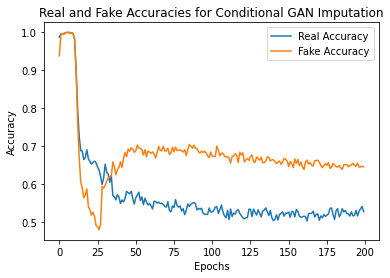

In [ ]:
_ = plt.plot(real_accuracy, label='Real Accuracy')
_ = plt.plot(fake_accuracy, label='Fake Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Real and Fake Accuracies for Conditional GAN Imputation")
plt.legend(loc="upper right")
plt.show()

In [ ]:
train_set_array = mnist_train.data.numpy()
test_set_array = mnist_test.data.numpy()

train_target = mnist_train.targets.numpy()
test_target = mnist_test.targets.numpy()

In [ ]:
res = []
for i in range(10):
  res.append(np.array(np.where(test_target == i)[0][:10]))

final_array = np.concatenate(res, axis=0)

Original Images


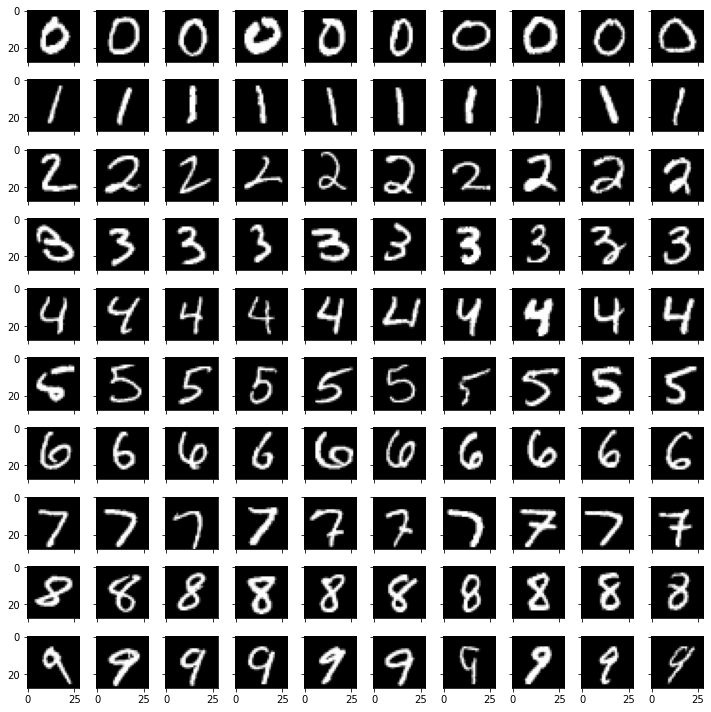

In [ ]:
# Original Images
print("Original Images")
fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(test_set_array[final_array][cnt], cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()

Imputed Images


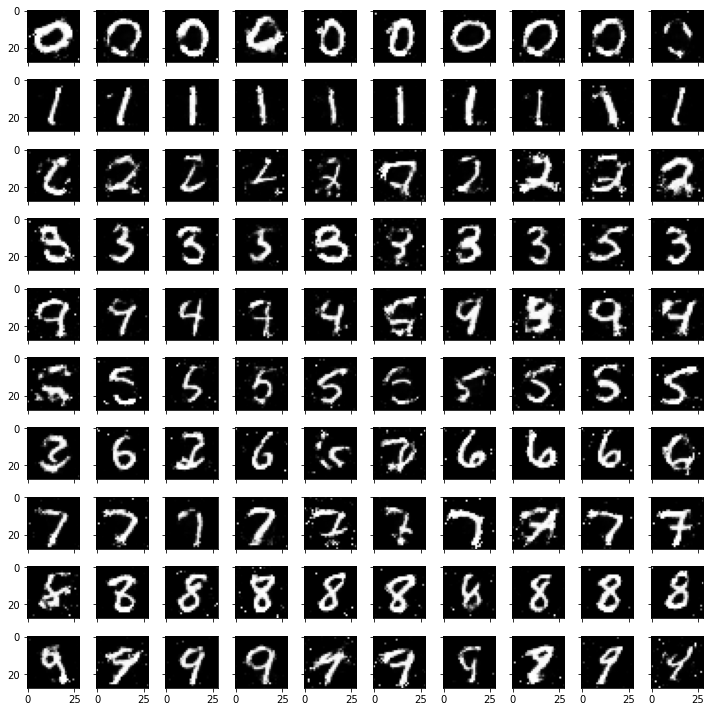

In [ ]:
# Output of Generator for MNIST Conditional Imputation

print("Imputed Images")

data = torch.from_numpy(test_set_array[final_array])

data = data / 255

# Discriminator Step

data = data.to(device).float()

# convert real_data from 0, 1 to -1, +1
data = ((data * 2) - 1)

# First Generation Pass
noise_vector = torch.randn(batch_size_train,100).to(device).float()

data_for_gen = data.reshape(100, 28,28)

data_patches = data_for_gen[:,10:20,10:20]

data_patches = data_patches.reshape(100, 100)


fake_data = Gen_Network(noise_vector, data_patches)

fake_data = fake_data.detach().cpu().numpy()

# Convert back 0,1
fake_data = (0.5 * fake_data) + 0.5

fake_data = fake_data.reshape(-1, 28, 28)

fig, axes = plt.subplots(10,10, figsize=(10,10), sharey=True, sharex=True)

cnt = 0
for i in range(10):
  for j in range(10):
    ax = axes[i,j]
    ax.imshow(fake_data[cnt, :, :], cmap='gray')
    cnt+= 1
fig.tight_layout() 
plt.show()

The imputed images look fairly good, whats interesting is that the middle square seems to always be the most clear in each image as we are just auto-encoding it from the real data